In [1]:
import numpy as np
import torch

from pytorch_lightning import Trainer
from torch.distributions import normal, uniform

from rgan.utils import TorchStandardScaler, \
                       SamplesDataset, NormToBoundsScaler, \
                       MechanisticModel

from rgan.rgan import rGAN, defaultNetsRGAN
from rgan.rejection import rejection_step
from rgan.cgan import cGAN, defaultNetsCGAN

seed = 1
torch.manual_seed(seed)

torch.set_default_dtype(torch.float64)

In [2]:
# For plotting
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
import matplotlib.patches as patches

c0 = '#252525'
c1 = '#1b9e77'
c2 = '#d95f02'
c3 = '#7570b3'
c4 = '#e7298a'

cmap = 'hot'
p1, p2 = -0.3, 1.1
fs, fs2, fs3 = 16, 20, 10
sns.set_context("paper", rc={"font.size":fs3, "axes.titlesize":fs, "axes.labelsize":fs3})

Define the mechanistic model (MM). 

Takes Tensor of parameters as input, and outputs Tensor of features

In [3]:
def model(x):
    X_A = [0.6, 0.6]
    X_B = [0.8, 0.6]
    X = torch.from_numpy(np.array([X_A, X_B])).type_as(x)
    y0 = 3.0
    y = torch.transpose(y0 + torch.matmul(X, torch.transpose(x, 0, 1)), 0, 1)
    return y

Generate data

- X is the parameter space for the MM. x_low and x_high define parameter bounds. Here we use a uniform prior over MM parameters

- Y is the MM output space. Typically this would be a low-dimensional feature set extracted from raw simulation output

- p_X are samples from the parameter prior

- p_Y are the push forward of q_X by the MM

- q_Y are observed samples in Y space - this is the target data

- X_N and Y_N are scalers to normalize values within X and Y space

In [4]:
# Settings for data
x_dim = 2
y_dim = 2
z_dim = 2

### Generating Data
n_samples = 10000
x_low = np.array([0.0, 0.0], dtype=np.float32)
x_high = np.array([2.0, 2.0], dtype=np.float32)

x_diff = x_high-x_low

# X as Gaussian, converted to uniform
loc = torch.zeros((x_dim,))
scale = torch.ones((x_dim,))
x_dist = normal.Normal(loc, scale)
X_N = NormToBoundsScaler(x_low, x_high)
p_X_N = x_dist.sample((n_samples,))
p_X = X_N.inverse(p_X_N)

# Push forward of prior by MM
p_Y = model(p_X)

# 'Observed' data - r-GAN target distribution
# Generated by running the model from uniform sampels in bounded region of X
groundtruth_X_dist = uniform.Uniform(low=torch.Tensor([0.85, 1.6]), 
                                     high=torch.Tensor([1.45, 1.8]))
groundtruth_X = groundtruth_X_dist.sample((n_samples,))
q_Y = model(groundtruth_X)

# Normalization in model output/observation space
Y_N = TorchStandardScaler()
Y_N.fit(q_Y)
y_scale = Y_N.std_
y_shift = Y_N.mean_

# Normalize model outputs
q_Y_N = Y_N(q_Y)
p_Y_N = Y_N(p_Y)

#### Figure of Data

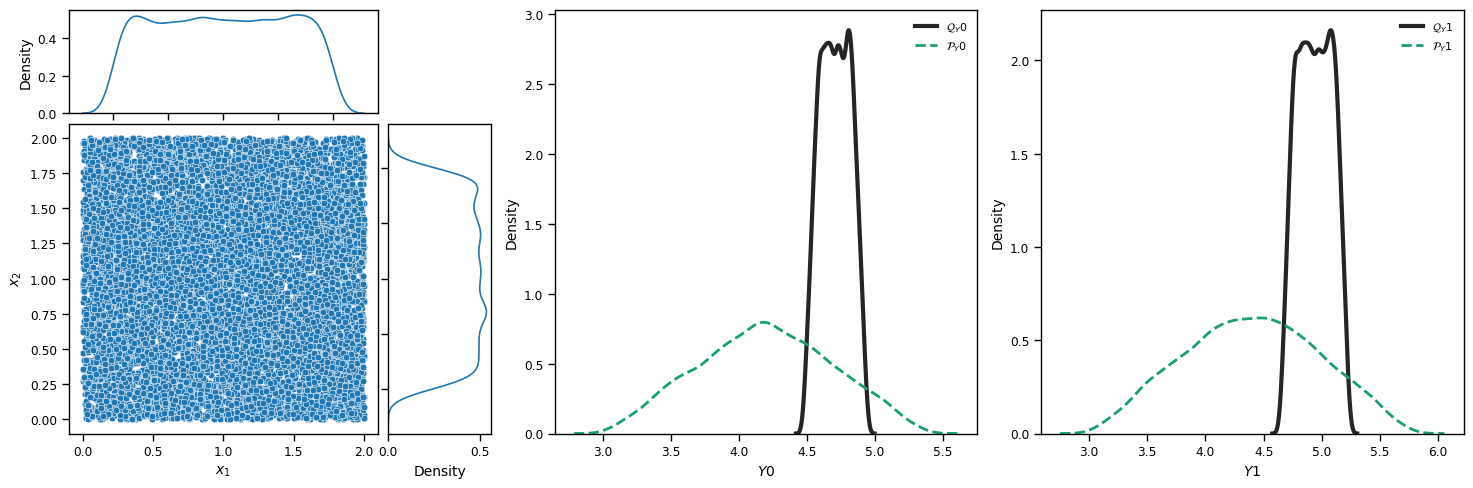

In [5]:
fig = plt.figure(figsize = (18, 5.5))
gs = fig.add_gridspec(1, 3, wspace = 0.15, hspace = 0.5)

# Left panel: p_X (parameter prior) distribution
gs1 = gs[0].subgridspec(2, 2, width_ratios=(3, 1), height_ratios=(1, 3), wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs1[1, 0])
sns.scatterplot(x=p_X.numpy()[:,0], y=p_X.numpy()[:,1], ax=ax)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(gs1[0, 0])
sns.kdeplot(x=p_X.numpy()[:,0], label=r'$x_1$')
ax.tick_params(axis="x", labelbottom=False)

ax = fig.add_subplot(gs1[1, 1])
sns.kdeplot(y=p_X.numpy()[:,1], label=r'$x_2$')
ax.tick_params(axis="y", labelleft=False)

# Middle panel: p_Y_0 (target distribution)
ax = fig.add_subplot(gs[1])
sns.kdeplot(q_Y.numpy()[:,0], color = c0, ax = ax, label = r'$\mathcal{Q}_Y0$', linewidth = 3)
sns.kdeplot(p_Y.numpy()[:,0], color = c1, ax = ax, label = r'$\mathcal{P}_Y0$', linewidth = 2, ls='--')
ax.set_xlabel('$Y0$')
ax.legend(prop = {'size': fs3-2}, frameon=False)

# Right panel: p_Y_1 (target distribution)
ax = fig.add_subplot(gs[2])
sns.kdeplot(q_Y.numpy()[:,1], color = c0, ax = ax, label = r'$\mathcal{Q}_Y1$', linewidth = 3)
sns.kdeplot(p_Y.numpy()[:,1], color = c1, ax = ax, label = r'$\mathcal{P}_Y1$', linewidth = 2, ls='--')
ax.set_xlabel('$Y1$')
ax.legend(prop = {'size': fs3-2}, frameon=False)

### Set up data and MM for rGAN model

SamplesDataset is a simple wrapper around samples data, in utils.py

In [5]:
p_X_N_dataset = SamplesDataset(p_X_N)
p_Y_N_dataset = SamplesDataset(p_Y_N)
q_Y_N_dataset = SamplesDataset(q_Y_N)

The MechanisticModel class wraps the 'model' function with scalers for normalization used during rGAN training

In [6]:
mm = MechanisticModel(model, X_N, Y_N)


4 Neural Networks are defined for the rGAN:

1. G: Generator network. Inputs: Z (base/latent variables (Gaussian)); Outputs: X_g (MM parameters)

2. R: Reconstruction net. Inputs: X_g (from Generator); Outputs: Z_g (Compared with Z) [for network stabilization]

3. D_X: X Discriminator. Inputs: X (Prior samples), X_g (from Generator); Outputs: Probability input is true prior sample

4. D_Y: Y Discriminator. Inputs: Y (Target samples), Y_g (from MM(X_g)); Outputs: Probability input is true target sample

defaultNetsRGAN is a helper function to set up these networks based on the Generator and Disciminator classes in rgan.py

In [25]:
G, R, D_X, D_Y = defaultNetsRGAN(z_dim=z_dim, x_dim=x_dim, y_dim=y_dim)

These hparams_dicts are used in two stages of the rGAN training

1. First stage: 'prior' -- train G, R, and D_X (i.e. not D_Y) so that G output matches parameter prior

2. Second stage: 'rgan' -- also train D_Y, and reduce wx (weight of loss from D_X), so that MM(X_g) output matches target

In [26]:
prior_hparams_dict = {'batch_size': 100,
                      'lr_g': 1e-4,
                      'lr_d_x': 1e-5,
                      'lr_d_y': 1e-5,
                      'wx': 1.0,
                      'wy': 0.0,
                      'wr': 3.0,
                      'epochs': 100,
                     }

rgan_hparams_dict = {'batch_size': 100,
                     'lr_g': 1e-4,
                     'lr_d_x': 1e-5,
                     'lr_d_y': 1e-5,
                     'wx': 0.03,
                     'wy': 1.0,
                     'wr': 3.0,
                     'epochs': 200,
                    }

rgan_model = rGAN(mm=mm, 
                  x_dataset=p_X_N_dataset, 
                  y_dataset=q_Y_N_dataset,
                  hparams=prior_hparams_dict,
                  G=G, R=R, D_X=D_X, D_Y=D_Y,
                  z_dim=z_dim,
                  train_stage = 'prior'
                  )

#### Train 'prior' stage

In [27]:
trainer = Trainer(max_epochs=rgan_model.hparams.epochs, accelerator='auto')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(rgan_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | mm   | MechanisticModel | 14    
1 | G    | Generator        | 81.3 K
2 | R    | Generator        | 81.3 K
3 | D_X  | Discriminator    | 81.2 K
4 | D_Y  | Discriminator    | 81.2 K
------------------------------------------
325 K     Trainable params
14        Non-trainable params
325 K     Total params
1.300     Total estimated model params size (MB)
/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:138: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")
`Trainer.fit` stopped: `max_epochs=100` reached.


rgan_model.prior_state_dict() is helper function to save and enable reloading of model trained to prior (e.g. to change target P_Y and resume from this stage)

In [29]:
state = rgan_model.prior_state_dict()

## r-GAN training stage

In [30]:
rgan_model.train_stage = 'rgan'
rgan_model.hparams.update(rgan_hparams_dict)

In [31]:
trainer = Trainer(max_epochs=rgan_model.hparams.epochs, accelerator='auto')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(rgan_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | mm   | MechanisticModel | 14    
1 | G    | Generator        | 81.3 K
2 | R    | Generator        | 81.3 K
3 | D_X  | Discriminator    | 81.2 K
4 | D_Y  | Discriminator    | 81.2 K
------------------------------------------
325 K     Trainable params
14        Non-trainable params
325 K     Total params
1.300     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Gather outputs from the trained model

In [33]:
z = torch.randn(p_X.shape[0], z_dim)
x_g_n = rgan_model.G(z).detach()
x_g = rgan_model.mm.X_N.inverse(x_g_n)
y_g_n = rgan_model.mm(x_g_n).detach()
y_g = rgan_model.mm.Y_N.inverse(y_g_n)

#### Trained rGAN results figure

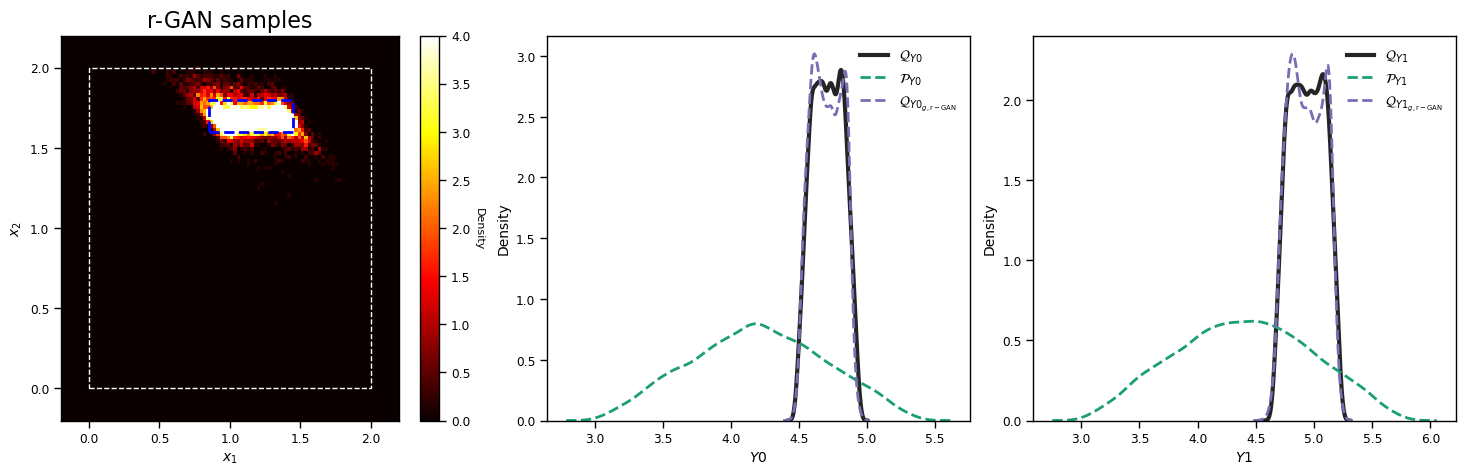

In [37]:
fig = plt.figure(figsize = (18, 5))
gs = fig.add_gridspec(1, 3, wspace = 0.15, hspace = 0.5)

# Left panel: Q_X_g density - samples in parameter space
ax = fig.add_subplot(gs[0])
extend1, extend2 = (x_high[0]-x_low[0])/10., (x_high[1]-x_low[1])/10.
r = [[x_low[0] - extend1, x_high[0] + extend1],
     [x_low[1] - extend2, x_high[1] + extend2]]
cbar = ax.hist2d(x_g.numpy()[:,0], x_g.numpy()[:, 1], cmap = cmap, bins = 100, density = True, 
                 range = r, vmax = 4, linewidth = 0, rasterized=True)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('r-GAN samples', fontsize = fs)

rect = patches.Rectangle((x_low[0], x_low[1]),  x_high[0] - x_low[0],
                         x_high[1] - x_low[1],
                         linewidth=1,edgecolor='w',facecolor='none', linestyle = '--')
ax.add_patch(rect)

rect2 = patches.Rectangle((0.85, 1.6),  1.45 - 0.85, 1.8 - 1.6,
                           linewidth=2, edgecolor='b', facecolor='none', linestyle = '--')
ax.add_patch(rect2)

cb = fig.colorbar(cbar[3], ax = ax)
cb.set_label('Density', fontsize=fs3-2, rotation=270, labelpad=10)

# Middle panel: p_Y0 (distributions in output feature space)
ax = fig.add_subplot(gs[1])

sns.kdeplot(q_Y.numpy()[:, 0], color = c0, ax = ax, label = r'$\mathcal{Q}_{Y0}$', linewidth = 3)

sns.kdeplot(p_Y.numpy()[:, 0], color = c1, ax = ax, label = r'$\mathcal{P}_{Y0}$', linewidth = 2, ls='--')

sns.kdeplot(y_g.numpy()[:, 0], color = c3, ax = ax, label = r'$\mathcal{Q}_{Y0_{g, \mathdefault{r-GAN}}}$', linewidth = 2, ls='--')

ax.set_xlabel('$Y0$')
ax.legend(prop = {'size': fs3}, frameon=False)

# Right panel: p_Y1 (distributions in output feature space)
ax = fig.add_subplot(gs[2])

sns.kdeplot(q_Y.numpy()[:, 1], color = c0, ax = ax, label = r'$\mathcal{Q}_{Y1}$', linewidth = 3)

sns.kdeplot(p_Y.numpy()[:, 1], color = c1, ax = ax, label = r'$\mathcal{P}_{Y1}$', linewidth = 2, ls='--')

sns.kdeplot(y_g.numpy()[:, 1], color = c3, ax = ax, label = r'$\mathcal{Q}_{Y1_{g, \mathdefault{r-GAN}}}$', linewidth = 2, ls='--')

ax.set_xlabel('$Y1$')
ax.legend(prop = {'size': fs3}, frameon=False)

# Rejection Algorithm

This algorithm performs the same experiment as above, using algorithm 2
from the manuscript, iterative rejection sampling

Start with 2,000,000 samples from the prior

In [20]:
n_samples_rej = 2000000
q_X_N_rej = x_dist.sample((n_samples_rej,))

Train a Gaussian Mixture model of the target data, to be able to calculate the log_prob of samples

In [21]:
from sklearn.mixture import GaussianMixture
q_Y_mix_pars = {"n_components": 40, "reg_covar": 1e-3, "tol": 1e-3, "max_iter": 100}
q_Y_gm = GaussianMixture(**q_Y_mix_pars).fit(q_Y_N)

Run rejection algorithm for 10 iterations:

In [22]:
q_X_iters = []
q_X_iters.append(q_X_N_rej)
for ii in range(10):
    q_X_iters.append(rejection_step(q_X_iters[-1], q_Y_gm, mm))
    print(f'Iteration: {ii}; q_X size: {q_X_iters[-1].shape[0]}')

Iteration: 0; q_X size: 134311
Iteration: 1; q_X size: 82158
Iteration: 2; q_X size: 71304
Iteration: 3; q_X size: 66598
Iteration: 4; q_X size: 63886
Iteration: 5; q_X size: 62145
Iteration: 6; q_X size: 60807
Iteration: 7; q_X size: 59762
Iteration: 8; q_X size: 58932
Iteration: 9; q_X size: 58307


In [23]:
x_rej_n = q_X_iters[-1][:10000,:]
x_rej = mm.X_N.inverse(x_rej_n)
y_rej = mm.MM(x_rej)

#### Rejection results figure

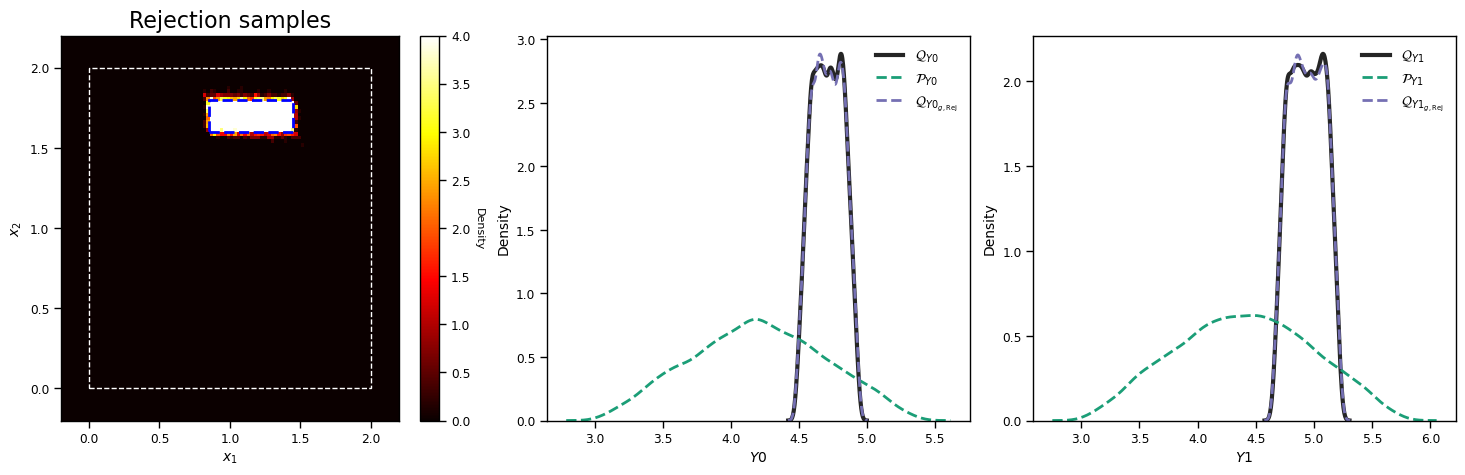

In [36]:
fig = plt.figure(figsize = (18, 5))
gs = fig.add_gridspec(1, 3, wspace = 0.15, hspace = 0.5)

# Left panel: Q_X_g density - samples in parameter space
ax = fig.add_subplot(gs[0])
extend1, extend2 = (x_high[0]-x_low[0])/10., (x_high[1]-x_low[1])/10.
r = [[x_low[0] - extend1, x_high[0] + extend1],
     [x_low[1] - extend2, x_high[1] + extend2]]
cbar = ax.hist2d(x_rej.numpy()[:,0], x_rej.numpy()[:, 1], cmap = cmap, bins = 100, density = True, 
                 range = r, vmax = 4, linewidth = 0, rasterized=True)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Rejection samples', fontsize = fs)

rect = patches.Rectangle((x_low[0], x_low[1]),  x_high[0] - x_low[0],
                         x_high[1] - x_low[1],
                         linewidth=1, edgecolor='w', facecolor='none', linestyle = '--')
ax.add_patch(rect)

rect2 = patches.Rectangle((0.85, 1.6),  1.45 - 0.85, 1.8 - 1.6,
                           linewidth=2, edgecolor='b', facecolor='none', linestyle = '--')
ax.add_patch(rect2)

cb = fig.colorbar(cbar[3], ax = ax)
cb.set_label('Density', fontsize=fs3-2, rotation=270, labelpad=10)

# Middle panel: p_Y0 (distributions in output feature space)
ax = fig.add_subplot(gs[1])

sns.kdeplot(q_Y.numpy()[:, 0], color = c0, ax = ax, label = r'$\mathcal{Q}_{Y0}$', linewidth = 3)

sns.kdeplot(p_Y.numpy()[:, 0], color = c1, ax = ax, label = r'$\mathcal{P}_{Y0}$', linewidth = 2, ls='--')

sns.kdeplot(y_rej.numpy()[:, 0], color = c3, ax = ax, label = r'$\mathcal{Q}_{Y0_{g, \mathdefault{Rej}}}$', linewidth = 2, ls='--')

ax.set_xlabel('$Y0$')
ax.legend(prop = {'size': fs3}, frameon=False)

# Right panel: p_Y1 (distributions in output feature space)
ax = fig.add_subplot(gs[2])

sns.kdeplot(q_Y.numpy()[:, 1], color = c0, ax = ax, label = r'$\mathcal{Q}_{Y1}$', linewidth = 3)

sns.kdeplot(p_Y.numpy()[:, 1], color = c1, ax = ax, label = r'$\mathcal{P}_{Y1}$', linewidth = 2, ls='--')

sns.kdeplot(y_rej.numpy()[:, 1], color = c3, ax = ax, label = r'$\mathcal{Q}_{Y1_{g, \mathdefault{Rej}}}$', linewidth = 2, ls='--')

ax.set_xlabel('$Y1$')
ax.legend(prop = {'size': fs3}, frameon=False)

# c-GAN

The c-GAN solution uses the samples from the prior used in the rejection algorithm to train an inverse surrogate model

This is overkill for some simple examples - we used the same number of runs of the mechanistic model in all examples, but actually this makes c-GAN training time unnecessarily long

The smaller training set of the initial prior samples can be used instead for faster c-GAN training for simple examples. This leads to slightly less uniform sampling in the final results than we show in the figure in the manuscript

In [38]:
p_X_N_cGAN = q_X_N_rej # 2M training set from Rejection sampling
# p_X_N_cGAN = p_X_N # 10k training set from training of prior discriminator in r-GAN
p_Y_N_cGAN = mm(p_X_N_cGAN)

In [39]:
p_X_N_cGAN_dataset = SamplesDataset(p_X_N_cGAN)
p_Y_N_cGAN_dataset = SamplesDataset(p_Y_N_cGAN)

In [40]:
Gc, Rc, Dc = defaultNetsCGAN(z_dim=z_dim, x_dim=x_dim, y_dim=y_dim)

In [41]:
cgan_hparams_dict = {'batch_size': 10000, # use larger e.g. 10000 for larger training set
                      'lr_g': 1e-4,
                      'lr_d': 1e-5,
                      'wx': 1.0,
                      'wr': 3.0,
                      'epochs': 200,
                     }

cgan_model = cGAN(x_dataset=p_X_N_cGAN_dataset, 
                  y_dataset=p_Y_N_cGAN_dataset,
                  hparams=cgan_hparams_dict,
                  G=Gc, R=Rc, D=Dc,
                  z_dim=z_dim
                  )

#### Train c-GAN

In [42]:
trainer = Trainer(max_epochs=cgan_model.hparams.epochs, accelerator='auto')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(cgan_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | G    | Generator     | 81.5 K
1 | R    | Generator     | 81.3 K
2 | D    | Discriminator | 81.4 K
---------------------------------------
244 K     Trainable params
0         Non-trainable params
244 K     Total params
0.977     Total estimated model params size (MB)
/home/hm/miniconda3/envs/pytorch_cuda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Gather outputs from the trained cGAN

In [44]:
z = torch.randn(p_X.shape[0], z_dim).type_as(cgan_model.G.model._modules['0']._parameters['weight'])
G_input_cgan = torch.concat([z, q_Y_N], dim=1)
x_g_n_cgan = cgan_model.G(G_input_cgan).detach()
x_g_cgan = mm.X_N.inverse(x_g_n_cgan).to('cpu')
y_g_n_cgan = mm(x_g_n_cgan).detach()
y_g_cgan = mm.Y_N.inverse(y_g_n_cgan).to('cpu')

#### c-GAN results figure

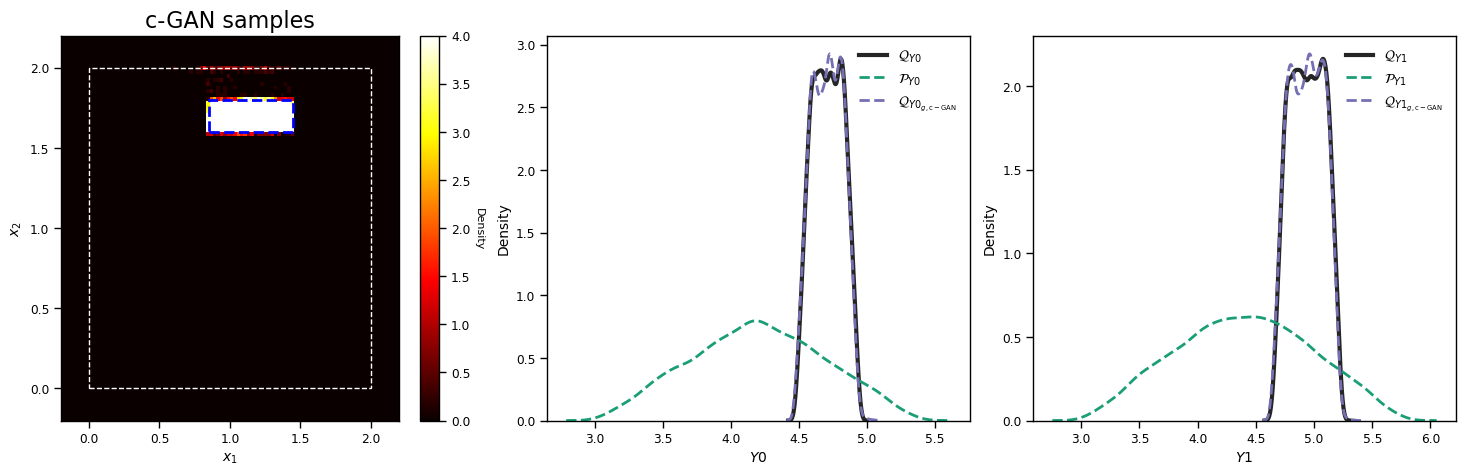

In [45]:
fig = plt.figure(figsize = (18, 5))
gs = fig.add_gridspec(1, 3, wspace = 0.15, hspace = 0.5)

# Left panel: Q_X_g density - samples in parameter space
ax = fig.add_subplot(gs[0])
extend1, extend2 = (x_high[0]-x_low[0])/10., (x_high[1]-x_low[1])/10.
r = [[x_low[0] - extend1, x_high[0] + extend1],
     [x_low[1] - extend2, x_high[1] + extend2]]
cbar = ax.hist2d(x_g_cgan.numpy()[:,0], x_g_cgan.numpy()[:, 1], cmap = cmap, bins = 100, density = True, 
                 range = r, vmax = 4, linewidth = 0, rasterized=True)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('c-GAN samples', fontsize = fs)

rect = patches.Rectangle((x_low[0], x_low[1]),  x_high[0] - x_low[0],
                         x_high[1] - x_low[1],
                         linewidth=1, edgecolor='w', facecolor='none', linestyle = '--')
ax.add_patch(rect)

rect2 = patches.Rectangle((0.85, 1.6),  1.45 - 0.85, 1.8 - 1.6,
                           linewidth=2, edgecolor='b', facecolor='none', linestyle = '--')
ax.add_patch(rect2)

cb = fig.colorbar(cbar[3], ax = ax)
cb.set_label('Density', fontsize=fs3-2, rotation=270, labelpad=10)

# Middle panel: p_Y0 (distributions in output feature space)
ax = fig.add_subplot(gs[1])

sns.kdeplot(q_Y.numpy()[:, 0], color = c0, ax = ax, label = r'$\mathcal{Q}_{Y0}$', linewidth = 3)

sns.kdeplot(p_Y.numpy()[:, 0], color = c1, ax = ax, label = r'$\mathcal{P}_{Y0}$', linewidth = 2, ls='--')

sns.kdeplot(y_g_cgan.numpy()[:, 0], color = c3, ax = ax, label = r'$\mathcal{Q}_{Y0_{g, \mathdefault{c-GAN}}}$', linewidth = 2, ls='--')

ax.set_xlabel('$Y0$')
ax.legend(prop = {'size': fs3}, frameon=False)

# Right panel: p_Y1 (distributions in output feature space)
ax = fig.add_subplot(gs[2])

sns.kdeplot(q_Y.numpy()[:, 1], color = c0, ax = ax, label = r'$\mathcal{Q}_{Y1}$', linewidth = 3)

sns.kdeplot(p_Y.numpy()[:, 1], color = c1, ax = ax, label = r'$\mathcal{P}_{Y1}$', linewidth = 2, ls='--')

sns.kdeplot(y_g_cgan.numpy()[:, 1], color = c3, ax = ax, label = r'$\mathcal{Q}_{Y1_{g, \mathdefault{c-GAN}}}$', linewidth = 2, ls='--')

ax.set_xlabel('$Y1$')
ax.legend(prop = {'size': fs3}, frameon=False)